# **Emotion Analysis**

# Importing Libraries and Dependencies

In [2]:
import os
import datetime as dt
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix

# Installing Contractions

In [18]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.9 MB/s eta 0:00:00


# Installing NLTK

In [19]:
!pip install --upgrade nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.


# Importing NLTK  

In [20]:
import nltk
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re

nltk.data.path.append('/usr/share/nltk_data')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

# Reading CSV

In [3]:
df=pd.read_csv('/kaggle/input/emotion-analysis-based-on-text/emotion_sentimen_dataset.csv')

# Data Preprocessing

In [3]:
df.head()

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


In [4]:
df.columns

Index(['Unnamed: 0', 'text', 'Emotion'], dtype='object')

In [5]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [6]:
df.rename(columns={'text':'Text'},inplace=True)

In [7]:
df.shape

(839555, 2)

In [8]:
df.isna().sum()

Text       0
Emotion    0
dtype: int64

In [9]:
df.duplicated().sum()

445733

In [10]:
df=df.drop_duplicates()

In [11]:
df.shape

(393822, 2)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393822 entries, 0 to 422745
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Text     393822 non-null  object
 1   Emotion  393822 non-null  object
dtypes: object(2)
memory usage: 9.0+ MB


In [13]:
df['Emotion'].value_counts()

Emotion
neutral       316935
love           17634
happiness      13038
sadness         8485
relief          8007
hate            6160
anger           5952
fun             4854
enthusiasm      4497
surprise        3430
empty           2697
worry           2072
boredom           61
Name: count, dtype: int64

# Data Distribution: Emotion Categories  

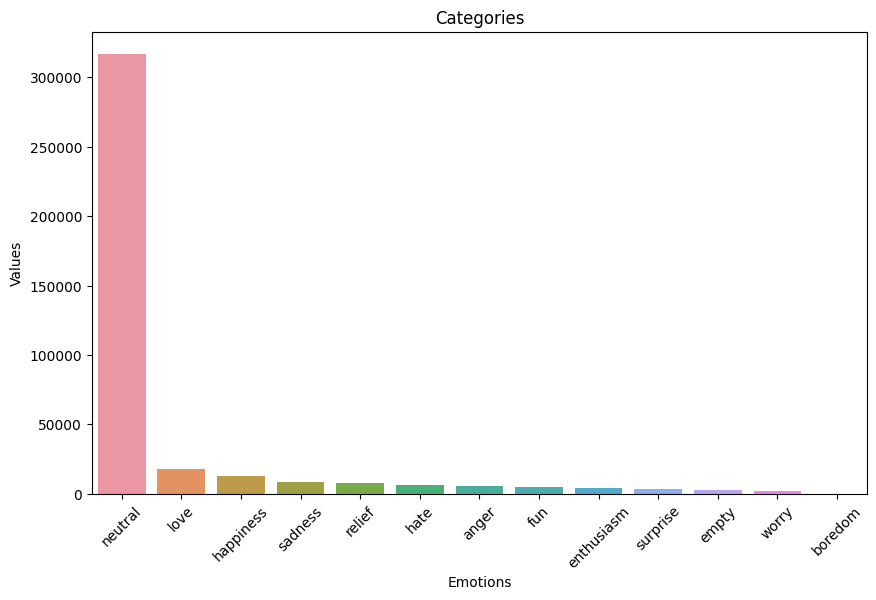

In [14]:
plt.figure(figsize=(10,6))
sns.barplot(x=df['Emotion'].value_counts().index,y=df['Emotion'].value_counts().values)
plt.xlabel('Emotions')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.title('Categories')
plt.show()

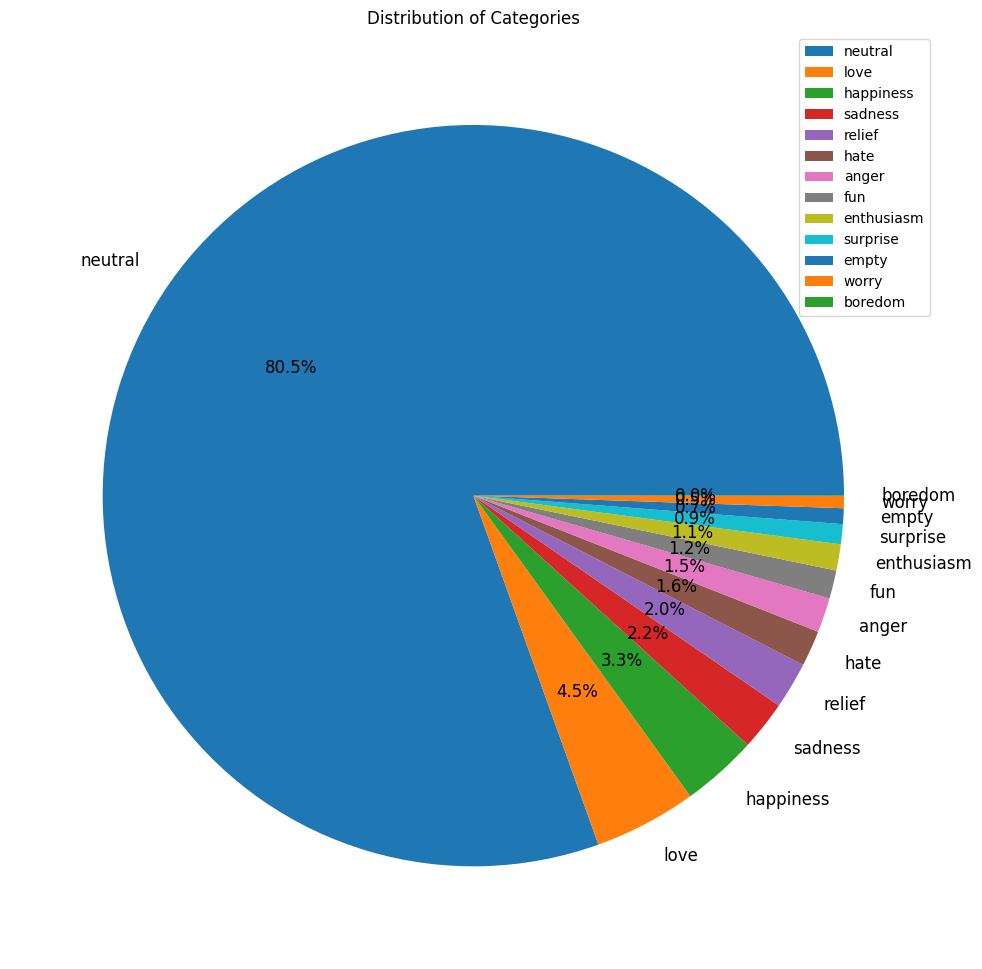

In [15]:
plt.figure(figsize=(10,10))
plt.pie(df['Emotion'].value_counts().values, labels=df['Emotion'].value_counts().index, autopct='%1.1f%%',textprops={'fontsize': 12})
plt.title('Distribution of Categories')
plt.legend(df['Emotion'].value_counts().index,loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()

# Word Cloud for Emotion Categories

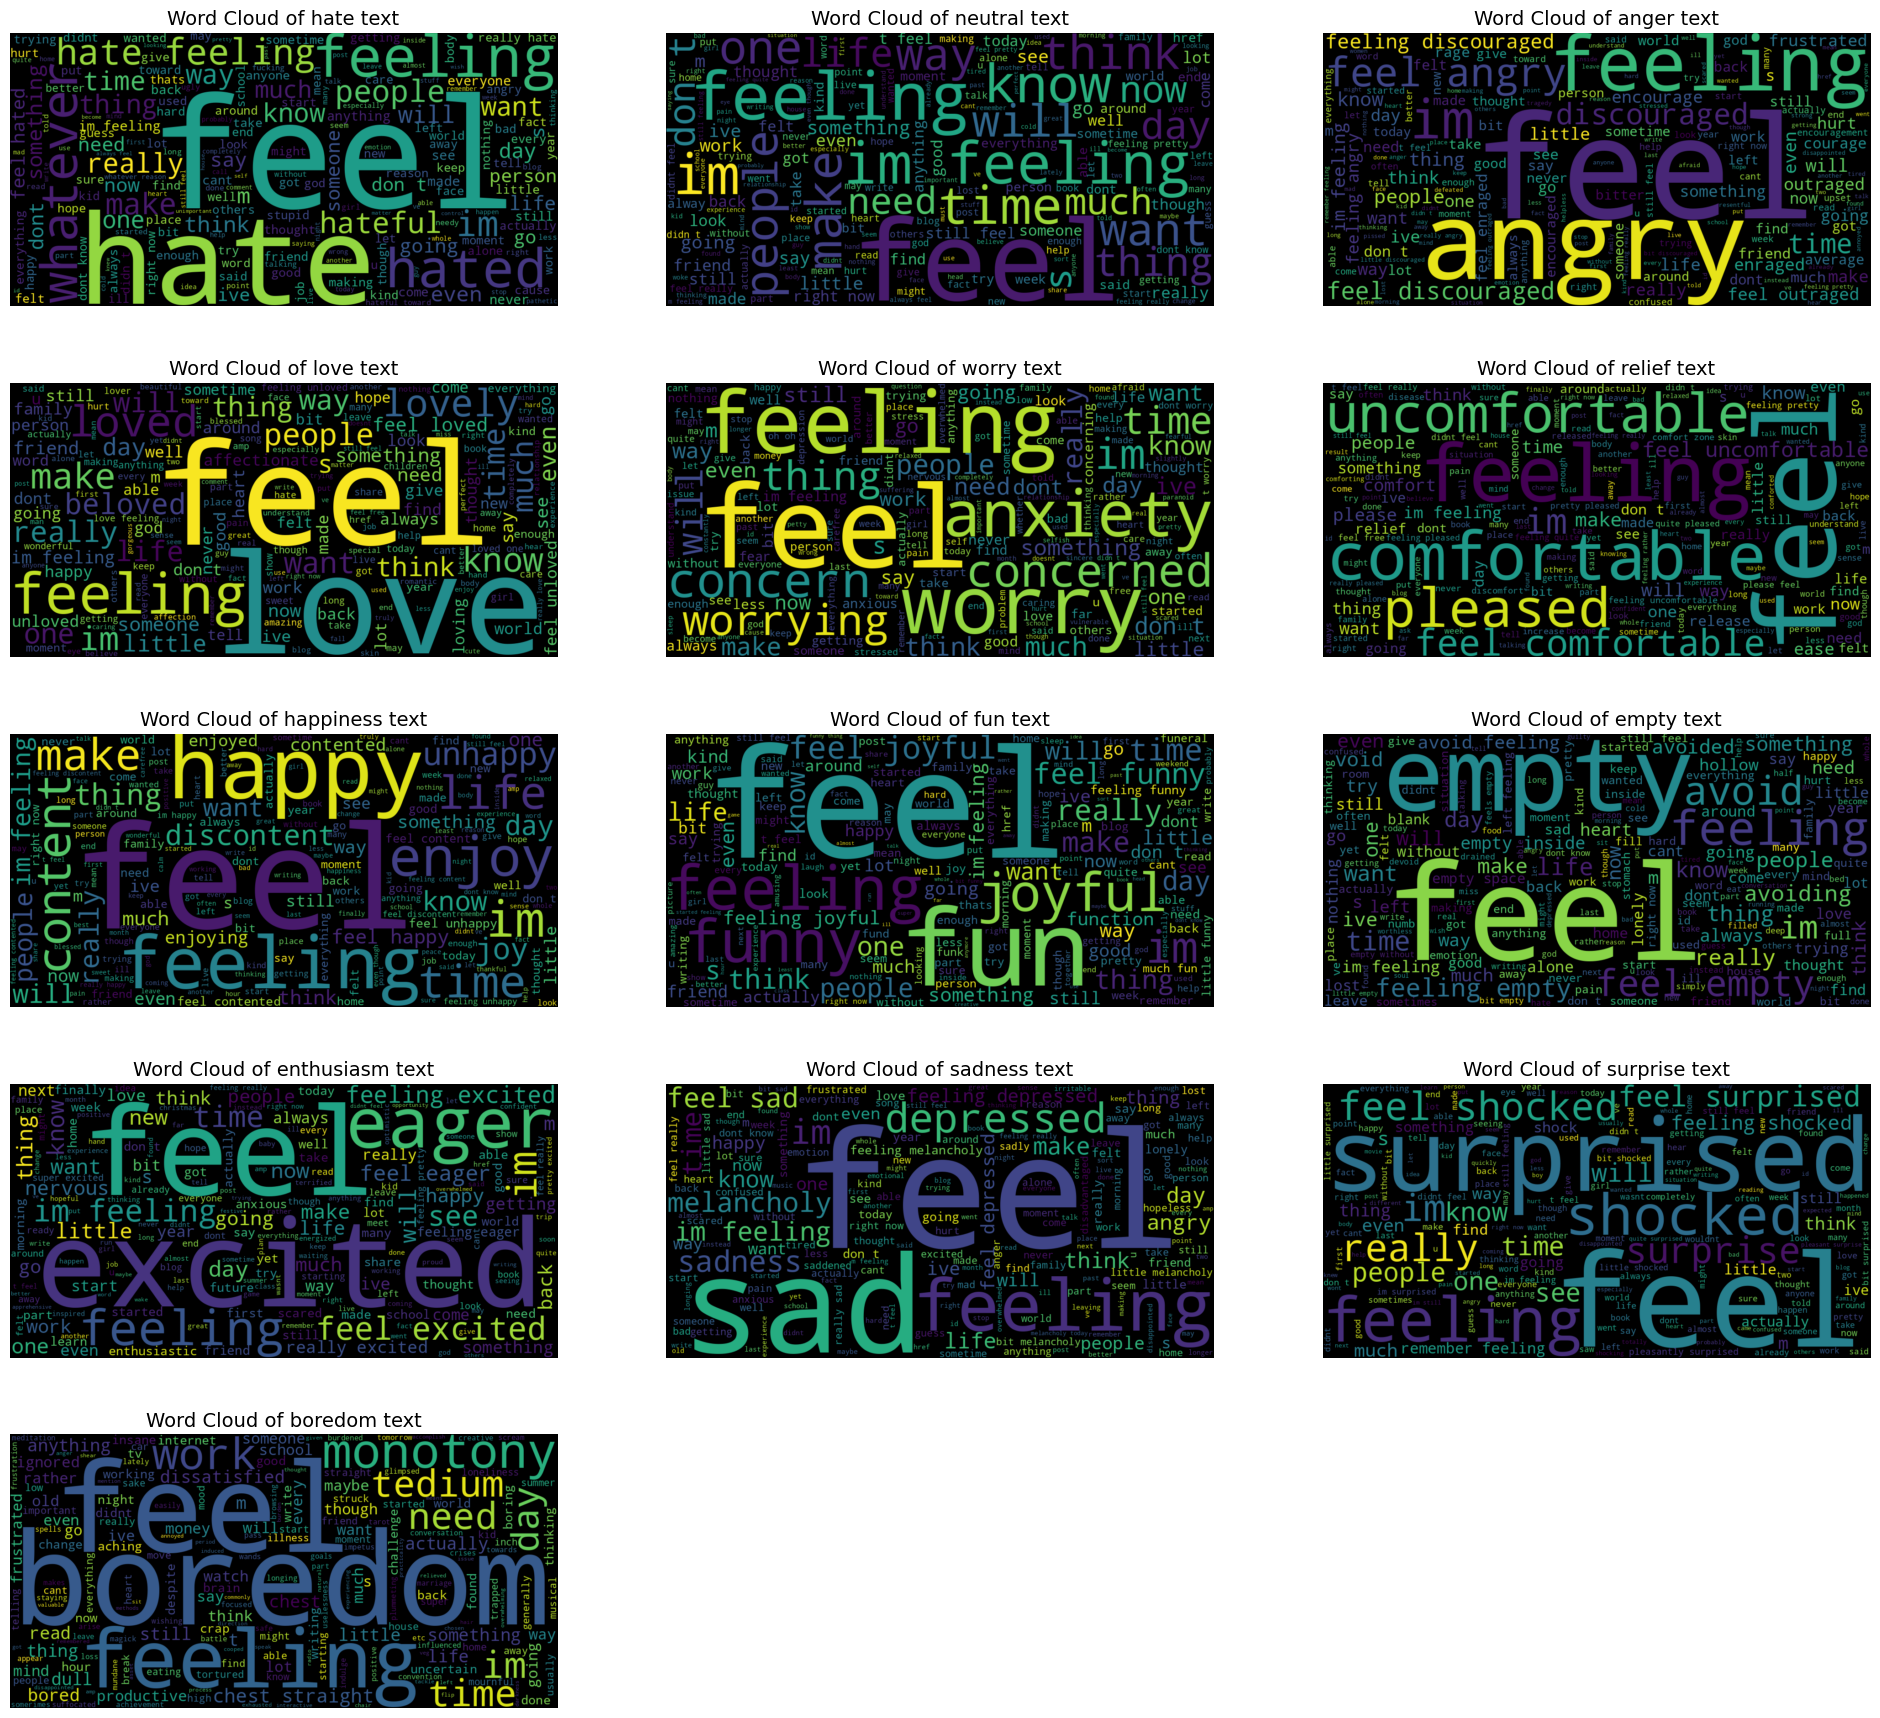

In [17]:
Emotions=df['Emotion'].unique()
plt.figure(figsize=(24,22))
for ind,emotion in enumerate(Emotions,start=1):
    combined=' '.join(df[df['Emotion']==emotion]['Text'])
    word_cloud=WordCloud(width=1200, height=600, background_color='black').generate(combined)
    plt.subplot(5,3,ind)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title(f'Word Cloud of {emotion} text',fontsize=14)
    plt.axis('off')

In [21]:
print(nltk.data.path)

['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/usr/share/nltk_data']


# Text Preprocessing:
- Expand contraction
- Remove URLs
- Remove special characters and punctuations
- Remove extra whitespaces
- Remove numerical values
- Convert to lowercase
- Tokenize text
- Remove stopwords
- Lemmatize tokens
- Join tokens back to a single string

In [22]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [23]:
def text_preprocess(text):
    text = contractions.fix(text)

    text = re.sub(r'http\S+|www\S+', '', text)

    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub(r'\d+', '', text)

    text = text.lower()

    tokens = word_tokenize(text)

    tokens = [word for word in tokens if word not in stop_words]

    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    processed_text = ' '.join(tokens)

    return processed_text

In [24]:
df['Preprocess_text']=df['Text'].apply(text_preprocess)

# Label Encoding

In [25]:
encoder=LabelEncoder()
df['Label']=encoder.fit_transform(df['Emotion'])

In [25]:
df.isna().sum()

Text               0
Emotion            0
Preprocess_text    9
Label              0
dtype: int64

In [26]:
print(df[df.isna().any(axis=1)]) 

              Text  Emotion Preprocess_text  Label
5962          when  neutral             NaN      8
12508           in  neutral             NaN      8
127352        once  neutral             NaN      8
160468    did very  neutral             NaN      8
200595   when i am  neutral             NaN      8
247422      when i  neutral             NaN      8
327678  once again  neutral             NaN      8
348780  when i was  neutral             NaN      8
354615    after my  neutral             NaN      8


In [27]:
df=df.dropna()

In [28]:
df.isna().sum()

Text               0
Emotion            0
Preprocess_text    0
Label              0
dtype: int64

# TF-IDF Vectorization  


In [8]:
tfidf_vectorizer = TfidfVectorizer()

x=tfidf_vectorizer.fit_transform(df['Preprocess_text'])
y=df['Label']
print(x.shape)
print(y.shape)

(393813, 67531)
(393813,)


# Train-Test Split 

In [9]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(315050, 67531)
(315050,)
(78763, 67531)
(78763,)


# Setting Up Callbacks for Model Training
## **Callback Details**

1. **ModelCheckpoint**  
   - Saves the best-performing model based on validation accuracy.  
2. **TensorBoard**  
   - Logs training metrics for visualization using TensorBoard.  

In [48]:
checkpoint = ModelCheckpoint('emotion-analysis.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

# MLP: MultiLayer Perceptron

In [72]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(x_train.shape[1],)),  
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(13, activation='softmax')  
])

## Compiling the Model

In [73]:
model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

## Model Summary

In [74]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                     │ (None, 256)                 │      17,288,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 13)                  │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,331,981 (66.12 MB)

 Trainable params: 17,331,085 (66.11 MB)

 Non-trainable params: 896 (3.50 KB)

## Training the Model

In [75]:
%%time
history = model.fit(x_train, y_train,
                   validation_data=(x_test,y_test),
                   batch_size=64,
                   epochs=10,
                   callbacks=[tensorboard, checkpoint]
                  )

Epoch 1/10
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5122 - loss: 1.7278
Epoch 1: val_accuracy improved from 0.80626 to 0.96100, saving model to emotion-analysis.keras
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 681s 137ms/step - accuracy: 0.5122 - loss: 1.7276 - val_accuracy: 0.9610 - val_loss: 0.2121
Epoch 2/10
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9273 - loss: 0.2769
Epoch 2: val_accuracy improved from 0.96100 to 0.98125, saving model to emotion-analysis.keras
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 62s 13ms/step - accuracy: 0.9273 - loss: 0.2769 - val_accuracy: 0.9812 - val_loss: 0.0857
Epoch 3/10
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9648 - loss: 0.1423
Epoch 3: val_accuracy improved from 0.98125 to 0.98951, saving model to emotion-analysis.keras
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - accuracy: 0.9648 - loss: 0.1423 - val_accuracy: 0.9895 - val_loss: 0.0537
Epoch 4/10
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9775 - loss: 

## Accuracy Visualization
The accuracy trends for both training and validation datasets.

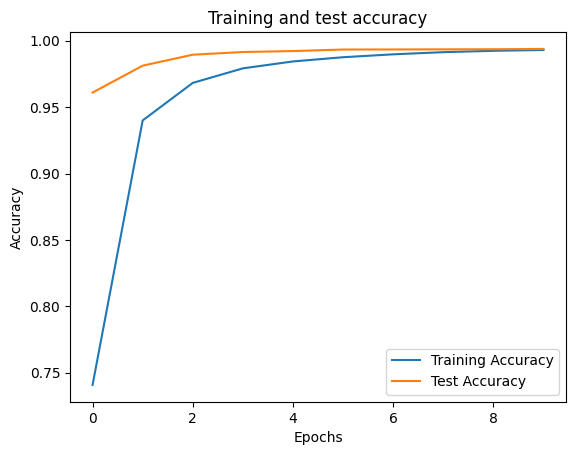

In [76]:
plt.title('Training and test accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Loss Visualization
The loss trends for both training and validation datasets.

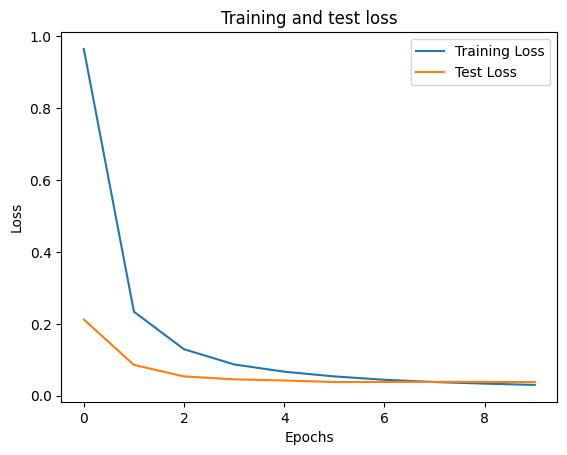

In [77]:
plt.title('Training and test loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Making Predictions

In [12]:
predictions = model.predict(x_test)  
print(predictions)

2462/2462 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step
[[9.52577375e-06 1.68064855e-06 2.54218730e-06 ... 2.28133081e-06
  3.78361642e-06 1.70883663e-06]
 [9.77074137e-07 1.21331720e-06 2.68576673e-06 ... 1.27027115e-05
  1.07869596e-06 6.16383375e-07]
 [4.58548857e-06 5.09390816e-07 6.22842038e-07 ... 2.82394922e-06
  4.72540364e-07 6.77365904e-07]
 ...
 [1.85842430e-06 1.24012331e-06 2.45376373e-06 ... 7.42884276e-06
  1.21466167e-06 8.72425062e-07]
 [2.03574791e-06 4.36136332e-07 6.66014728e-07 ... 2.15842306e-06
  5.04235800e-07 2.31894816e-07]
 [3.52421671e-06 1.42602528e-06 2.12957730e-06 ... 3.31973115e-06
  2.20049083e-06 1.13223393e-06]]


In [13]:
predictions.shape

(78763, 13)

## Evaluation on Training Data

In [14]:
train_loss, train_accuracy = model.evaluate(x_train,y_train, verbose=1)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

9846/9846 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.9989 - loss: 0.0057
Train Loss: 0.0058502922765910625
Train Accuracy: 0.9988541603088379


## Evaluation on Testing Data

In [15]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2462/2462 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9937 - loss: 0.0375
Test Loss: 0.03806014358997345
Test Accuracy: 0.9938676953315735


## Classification Report
- Precision
- Recall
- F1-Score
- Support

In [16]:
y = np.argmax(predictions, axis=1)
cr = classification_report(y_true=y_test, y_pred=y)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1179
           1       0.00      0.00      0.00        10
           2       1.00      0.97      0.98       542
           3       1.00      0.98      0.99       856
           4       0.99      0.96      0.97      1001
           5       0.99      0.98      0.99      2596
           6       0.99      0.97      0.98      1236
           7       0.99      0.98      0.99      3469
           8       0.99      1.00      1.00     63431
           9       0.99      0.96      0.98      1596
          10       1.00      0.98      0.99      1728
          11       0.99      0.97      0.98       708
          12       0.93      0.89      0.91       411

    accuracy                           0.99     78763
   macro avg       0.91      0.89      0.90     78763
weighted avg       0.99      0.99      0.99     78763



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix

In [17]:
print("Confusion Matrix:")
cm=confusion_matrix(y_true=y_test, y_pred=y)
print(cm)

Confusion Matrix:
[[ 1123     0     0     0     0     0     0     0    56     0     0     0
      0]
 [    0     0     0     0     2     0     0     0     7     0     0     0
      1]
 [    0     0   525     0     0     1     0     0    10     0     5     1
      0]
 [    0     0     0   839     0     0     0     1    14     0     1     0
      1]
 [    1     0     0     0   959     4     0     0    35     2     0     0
      0]
 [    4     0     0     0     0  2537     0     0    48     5     0     0
      2]
 [    1     0     0     0     0     4  1197     0    30     3     0     0
      1]
 [    1     0     0     0     2     2     5  3413    42     2     0     0
      2]
 [    0     0     0     0     0     1     1     5 63406     1     0     0
     17]
 [    3     0     0     0     0     0     0     0    55  1537     0     0
      1]
 [    2     0     0     1     1     4     1     3    20     1  1691     1
      3]
 [    1     0     0     0     0     2     1     6     9     0     0  

Confusion Matrix


<Axes: >

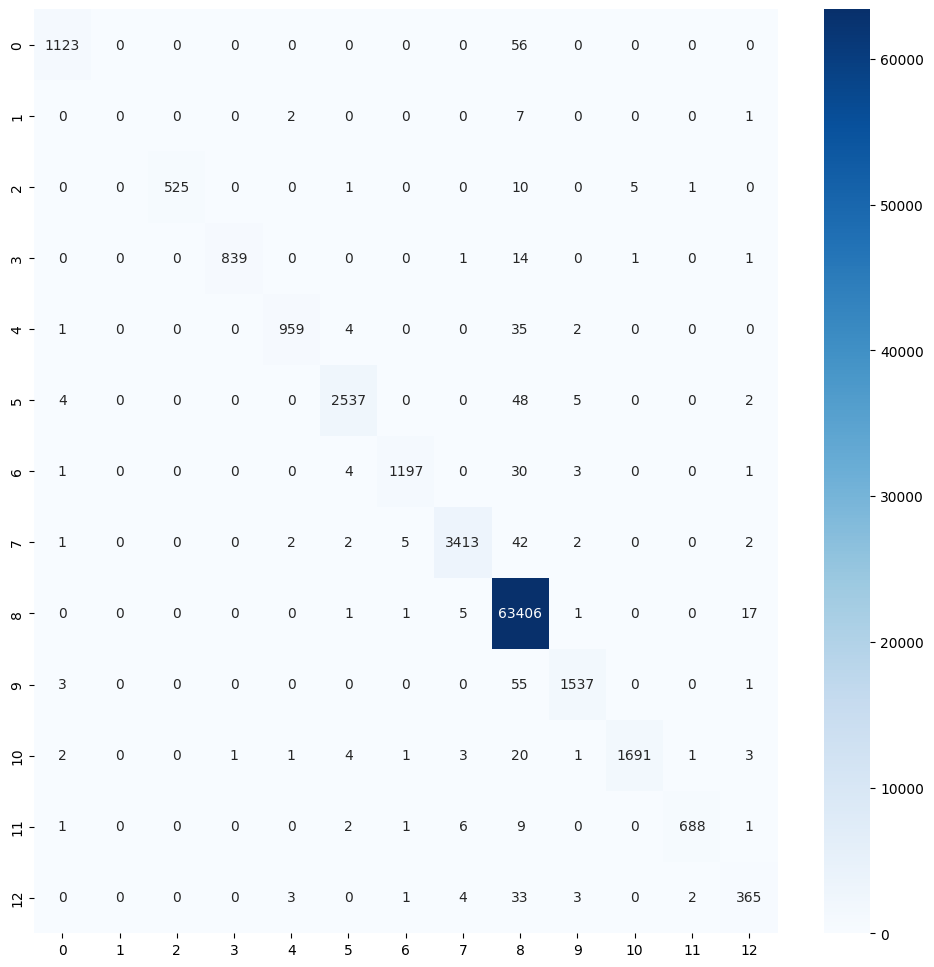

In [23]:
print('Confusion Matrix')
cm_df = pd.DataFrame(cm, columns=y_test.unique())
plt.figure(figsize=(12,12))
sns.heatmap(cm_df, annot=True, fmt='d',cmap='Blues', xticklabels=set(y_train), yticklabels=set(y_train))

# Text Tokenization  

In [29]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df["Preprocess_text"])
sequences = tokenizer.texts_to_sequences(df["Preprocess_text"])

In [31]:
maxlen = max(len(tokens) for tokens in sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 78


# Padding Sequences  

In [32]:
padded_sequences=pad_sequences(sequences, maxlen=maxlen)

# Train-Test Split

In [34]:
x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm=train_test_split(padded_sequences, df['Label'], test_size=0.2, random_state=42)

In [35]:
print(x_train_lstm.shape)
print(y_train_lstm.shape)
print(x_test_lstm.shape)
print(y_test_lstm.shape)

(315050, 78)
(315050,)
(78763, 78)
(78763,)


In [36]:
x_train_lstm

array([[    0,     0,     0, ...,   139,   534,   392],
       [    0,     0,     0, ...,   506,  5756,    67],
       [    0,     0,     0, ..., 50372, 50373,   551],
       ...,
       [    0,     0,     0, ...,    44,    18,  2131],
       [    0,     0,     0, ...,  1034, 15544,   954],
       [    0,     0,     0, ...,    47,     1,   550]], dtype=int32)

In [37]:
max_vocab=len(tokenizer.word_index) + 1

In [17]:
print(maxlen)
print(max_vocab)

78
67556


# Recurrent Neural Network (RNN) with LSTM

In [20]:
model_lstm = Sequential([
    Embedding(input_dim=max_vocab, output_dim=128, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(13, activation='softmax')  
])

## Compiling the Model

In [21]:
model_lstm.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

## Model Summary

In [23]:
model_lstm.build(input_shape=(None, maxlen))
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 78, 128)             │       8,647,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 78, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 13)                  │             429 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,789,837 (33.53 MB)

 Trainable params: 8,789,773 (33.53 MB)

 Non-trainable params: 64 (256.00 B)

## Training the Model

In [25]:
%%time
history = model_lstm.fit(x_train_lstm, y_train_lstm,
                   validation_data=(x_test_lstm,y_test_lstm),
                   batch_size=64,
                   epochs=10,
                   callbacks=[tensorboard, checkpoint]
                  )

Epoch 1/10
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7146 - loss: 1.3971
Epoch 1: val_accuracy improved from -inf to 0.95287, saving model to emotion-analysis.keras
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 1745s 352ms/step - accuracy: 0.7147 - loss: 1.3970 - val_accuracy: 0.9529 - val_loss: 0.2031
Epoch 2/10
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9346 - loss: 0.2375
Epoch 2: val_accuracy improved from 0.95287 to 0.98240, saving model to emotion-analysis.keras
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 1738s 353ms/step - accuracy: 0.9346 - loss: 0.2375 - val_accuracy: 0.9824 - val_loss: 0.0777
Epoch 3/10
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9652 - loss: 0.1340
Epoch 3: val_accuracy improved from 0.98240 to 0.99107, saving model to emotion-analysis.keras
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 1756s 357ms/step - accuracy: 0.9652 - loss: 0.1340 - val_accuracy: 0.9911 - val_loss: 0.0525
Epoch 4/10
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9765 -

## Accuracy Visualization
The accuracy trends for both training and validation datasets.

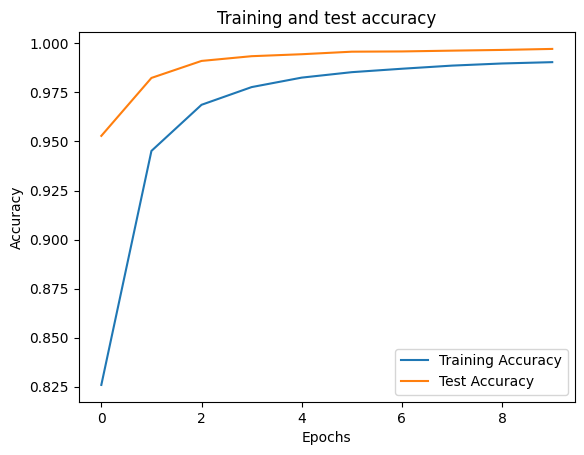

In [26]:
plt.title('Training and test accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Loss Visualization
The loss trends for both training and validation datasets.

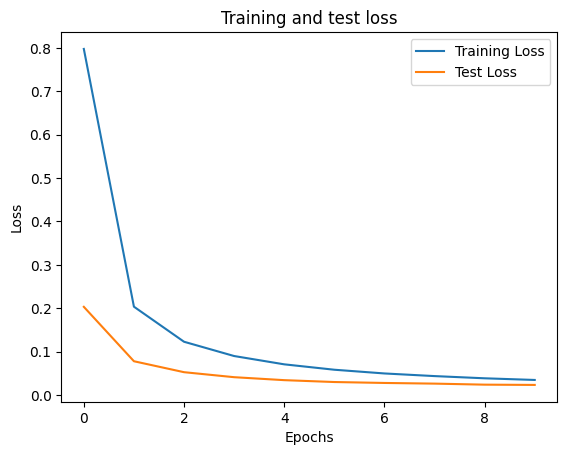

In [27]:
plt.title('Training and test loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Making Predictions

In [39]:
predictions_lstm = model_lstm.predict(x_test_lstm)  
print(predictions_lstm)

2462/2462 ━━━━━━━━━━━━━━━━━━━━ 182s 74ms/step
[[9.8544353e-07 5.8438076e-07 1.0287567e-06 ... 1.0749432e-06
  5.9793950e-07 2.8872856e-07]
 [5.8048198e-07 2.5815984e-07 5.7854709e-07 ... 4.8926023e-07
  3.1302531e-07 1.1696555e-07]
 [6.6274993e-07 3.3441174e-07 9.6573297e-07 ... 6.8264768e-07
  3.5421846e-07 1.9126813e-07]
 ...
 [8.0637386e-07 4.3164184e-07 1.6758037e-06 ... 8.4444258e-07
  5.9524888e-07 2.9525131e-07]
 [3.7515244e-07 1.7812818e-07 1.0590722e-06 ... 7.3577758e-07
  2.0227866e-07 1.4815600e-07]
 [1.3154358e-06 5.6268783e-07 8.4240492e-07 ... 7.3580981e-07
  6.2829139e-07 2.6821979e-07]]


In [40]:
predictions_lstm.shape

(78763, 13)

## Evaluation on Training Data

In [41]:
train_loss_lstm, train_accuracy_lstm = model_lstm.evaluate(x_train_lstm, y_train_lstm, verbose=1)
print(f"Train Loss: {train_loss_lstm}")
print(f"Train Accuracy: {train_accuracy_lstm}")

9846/9846 ━━━━━━━━━━━━━━━━━━━━ 715s 73ms/step - accuracy: 0.9990 - loss: 0.0057
Train Loss: 0.005695383995771408
Train Accuracy: 0.9989747405052185


## Evaluation on Testing Data

In [42]:
test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(x_test_lstm, y_test_lstm, verbose=1)
print(f"Test Loss: {test_loss_lstm}")
print(f"Test Accuracy: {test_accuracy_lstm}")

2462/2462 ━━━━━━━━━━━━━━━━━━━━ 179s 73ms/step - accuracy: 0.9972 - loss: 0.0236
Test Loss: 0.023101095110177994
Test Accuracy: 0.9971941113471985


## Classification Report
- Precision
- Recall
- F1-Score
- Support

In [43]:
y_lstm = np.argmax(predictions_lstm, axis=1)
cr_lstm = classification_report(y_true=y_test_lstm, y_pred=y_lstm)
print(cr_lstm)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1179
           1       0.00      0.00      0.00        10
           2       1.00      0.97      0.99       542
           3       1.00      0.99      1.00       856
           4       0.99      0.98      0.99      1001
           5       1.00      0.99      1.00      2596
           6       0.99      0.99      0.99      1236
           7       0.99      1.00      0.99      3469
           8       1.00      1.00      1.00     63431
           9       1.00      0.99      0.99      1596
          10       1.00      0.99      0.99      1728
          11       0.99      0.98      0.99       708
          12       0.90      0.92      0.91       411

    accuracy                           1.00     78763
   macro avg       0.91      0.91      0.91     78763
weighted avg       1.00      1.00      1.00     78763



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix

In [44]:
print("Confusion Matrix:")
cm_lstm=confusion_matrix(y_true=y_test_lstm, y_pred=y_lstm)
print(cm_lstm)

Confusion Matrix:
[[ 1168     0     0     0     0     0     0     0    10     0     0     0
      1]
 [    3     0     0     0     0     0     0     0     4     0     0     0
      3]
 [    0     0   527     1     1     1     0     2     3     0     6     0
      1]
 [    0     0     0   850     0     0     0     0     4     0     1     0
      1]
 [    4     0     0     0   979     0     1     0    16     0     0     0
      1]
 [    1     0     0     0     0  2580     1     0    11     1     0     0
      2]
 [    1     0     0     0     0     2  1225     0     4     1     0     0
      3]
 [    0     0     0     0     0     0     1  3452    14     0     0     0
      2]
 [    0     0     0     0     0     1     1     6 63394     3     0     0
     26]
 [    4     0     0     0     0     0     0     0     9  1582     0     0
      1]
 [    0     0     0     0     0     3     1     1     7     0  1713     1
      2]
 [    1     0     0     0     1     2     0    10     2     0     0  

Confusion Matrix


<Axes: >

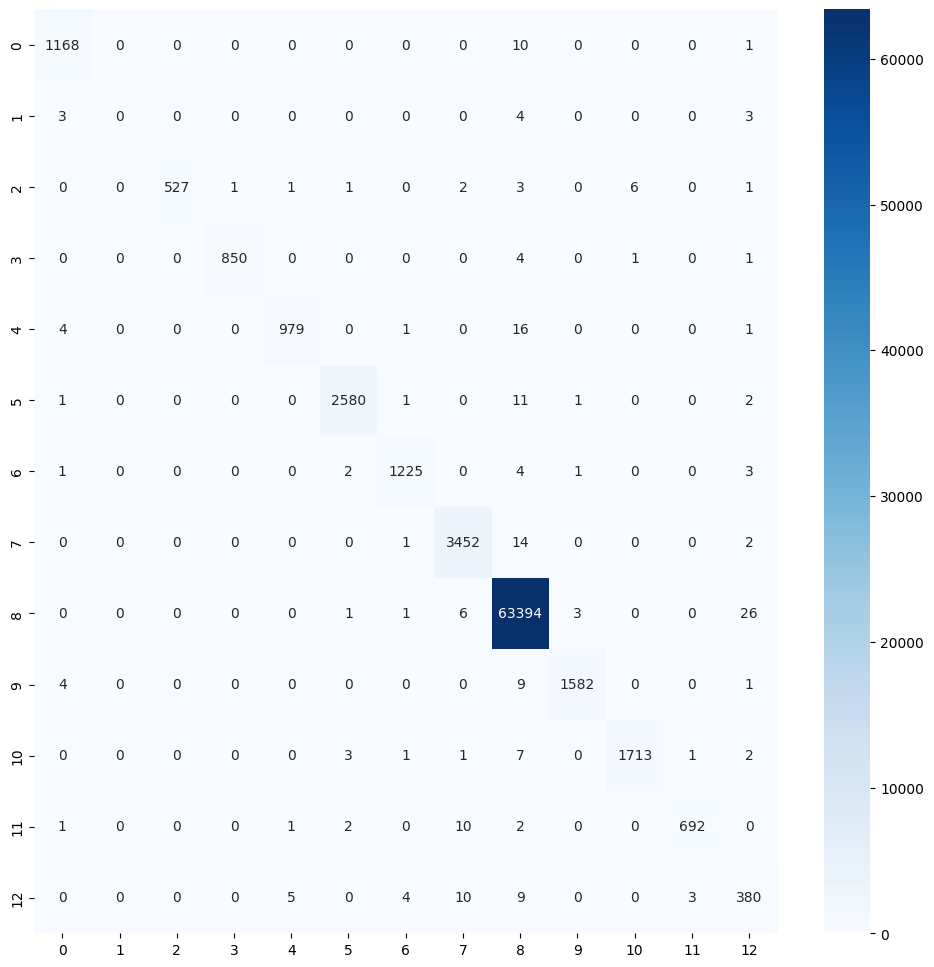

In [52]:
print('Confusion Matrix')
cm_df_lstm = pd.DataFrame(cm_lstm, columns=y_test.unique())
plt.figure(figsize=(12,12))
sns.heatmap(cm_df_lstm, annot=True, fmt='d',cmap='Blues', xticklabels=set(y_train_lstm), yticklabels=set(y_train_lstm))